In [1]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

from ABC_algorithm import ABC 
from post_adjustment import PostProcess

Populating the interactive namespace from numpy and matplotlib


## Normal example

In [2]:
######
# set up for the normal ABC example
######

prior_mean = -3.0
prior_sd = 1
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=200)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print post_mean, "is posterior mean"
print post_sd, "is posterior std dev"

-0.0437067576271 is posterior mean
0.00497512437811 is posterior std dev


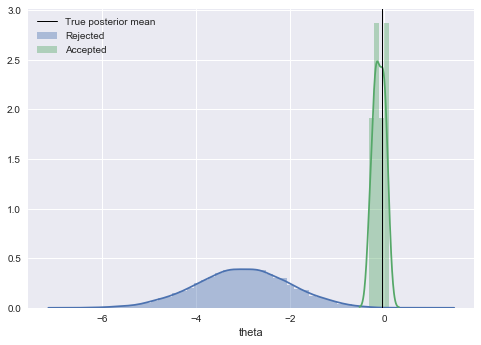

In [3]:
######
# run ABC for the normal example
######

epsilon = 0.2
n = 10000
df = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, epsilon, data , n)

######
# plot the accepted and rejected params
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    sns.distplot(sub_df.theta, ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.savefig('plots/1d_normal_abc.pdf')

here
1.8288647313
(20,)


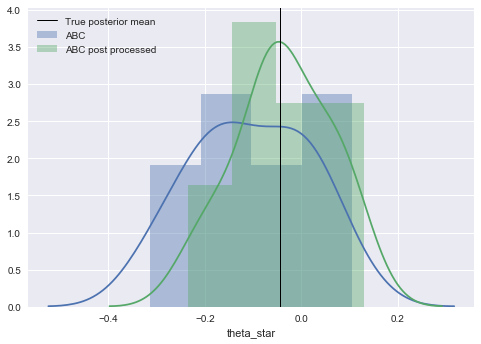

In [8]:
df_abc_accepted_post_processed = PostProcess(df, NormalSummary, data, weighted=True)

df_abc_accepted = df[df.accept == 1]

fig, ax = plt.subplots()

sns.distplot(df_abc_accepted.theta, ax=ax, kde = True, label='ABC') #norm_hist =True,
sns.distplot(df_abc_accepted_post_processed.theta_star, ax=ax, kde = True, label='ABC post processed')
plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.show()
plt.savefig('plots/1d_normal_abc_report_postadj.pdf')

## Evaluate MSE

In [17]:
epsilon_count = 10
epsilon = 0
epsilon_increment = 0.1

k = 1000
n = 1000

error_epsilon_list = []

for _ in range(epsilon_count):
    epsilon = epsilon + epsilon_increment
    #print "epsilon:{}".format(epsilon)

    abc_post_means = []
    dist_from_truth = []

    for i in range(k):
        #print "Iteration:{}".format(i)
        df_ei = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, epsilon, data, n)
        abc_post_mean = df_ei[df_ei.accept == 1].theta.mean()
        abc_post_means.append(abc_post_mean)
        dist_from_truth.append(abs(abc_post_mean - post_mean))
    
    squared_dist_from_truth = np.power(dist_from_truth,2)
    mse = np.mean(squared_dist_from_truth)
    mse_err = 1.96*np.std(squared_dist_from_truth)
    
    mc_bias = np.mean(dist_from_truth)
    mc_bias_err = 1.96*np.std(dist_from_truth)
    
    var = np.var(abc_post_means)
    
    mse_check = np.add(var, np.power(mc_bias,2))
    
    error_epsilon_list.append({'epsilon':epsilon ,
                               'bias':mc_bias, 'bias_err':mc_bias_err, 
                               'mse':mse, 'mse_err':mse_err,
                               'var':var,
                               'mse_check':mse_check
                              })
    
mse_df = pd.DataFrame(error_epsilon_list)
#mse_df.bias = mse_df.mse - mse_df.variance


#plt.scatter(mse_df['epsilon'], mse_df['bias'])
#pylab.errorbar(mse_df['epsilon'], mse_df['bias'],yerr=mse_df['bias_err'],linestyle='None') 
#plt.show()
#plt.scatter(mse_df['epsilon'], mse_df['mse'])
#pylab.errorbar(mse_df['epsilon'], mse_df['mse'],yerr=mse_df['mse_err'],linestyle='None')
#plt.show()
#sns.regplot(x=mse_df.epsilon, y=mse_df.variance, marker="+", fit_reg=False, label='Variance')
#sns.regplot(x=mse_df.epsilon, y=mse_df.bias, marker="+", fit_reg=False, label='Bias')
#plt.legend(loc='upper left')



In [18]:
print mse_df

       bias  bias_err  epsilon       mse  mse_check   mse_err       var
0       NaN       NaN      0.1       NaN        NaN       NaN       NaN
1       NaN       NaN      0.2       NaN        NaN       NaN       NaN
2       NaN       NaN      0.3       NaN        NaN       NaN       NaN
3       NaN       NaN      0.4       NaN        NaN       NaN       NaN
4  0.212785  0.191205      0.5  0.054794   0.056855  0.089368  0.011578
5  0.286686  0.183503      0.6  0.090954   0.091477  0.106077  0.009288
6  0.363238  0.179451      0.7  0.140324   0.140361  0.126717  0.008420
7  0.450565  0.159777      0.8  0.209654   0.209654  0.141979  0.006645
8  0.535921  0.153162      0.9  0.293317   0.293317  0.161608  0.006106
9  0.620056  0.138512      1.0  0.389463   0.389463  0.169125  0.004994


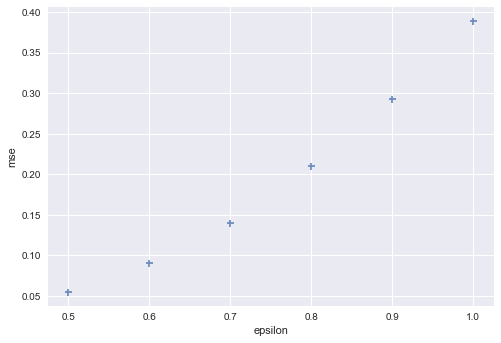

In [19]:
sns.regplot(x=mse_df.epsilon, y=mse_df.mse, marker="+", fit_reg=False, label='MSE')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.mse, yerr=mse_df.mse_err, linestyle="None")

#plt.savefig('plots/1d_normal_mse_epsilon_k{}_n{}_.pdf'.format(k,n))


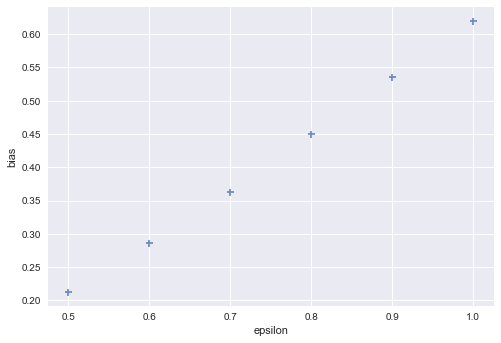

In [20]:
sns.regplot(x=mse_df.epsilon, y=mse_df.bias, marker="+", fit_reg=False, label='bias')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.bias, yerr=mse_df.bias_err, linestyle="None")
#plt.savefig('plots/1d_normal_bias_epsilon_k{}_n{}_.pdf'.format(k,n))

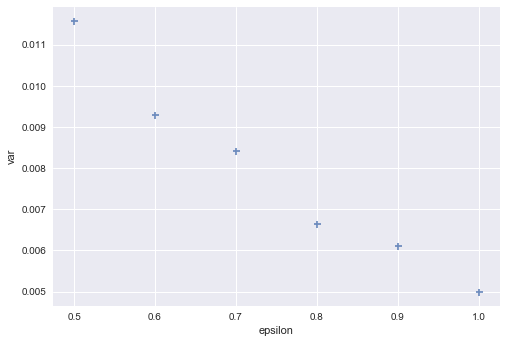

In [21]:
sns.regplot(x=mse_df.epsilon, y=mse_df['var'], marker="+", fit_reg=False, label='MSE')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.bias, yerr=mse_df.bias_err, linestyle="None")
#plt.savefig('plots/1d_normal_var_epsilon_k{}_n{}_.pdf'.format(k,n))